### Computation Matrics
* Evaluation: 
To evaluate the models we use several standard metrics in the recommendation field, including the area under the ROC curve (AUC), mean reciprocal rank (MRR), and normalized discounted cumulative gain (nDCG@K) for K shown recommendations. To address the normative complexities inherent in news recommendations, the test set incorporates samples specifically designed to assess models based on normative properties. This includes evaluating models on Beyond-Accuracy Objectives, such as intra-list diversity, serendipity, novelty, coverage, among others. The final result is the average of these metrics across all impression logs.

### Library Imports

In [132]:
import warnings
warnings.filterwarnings("ignore")
import os
import time
import glob
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import pyarrow.parquet as pa
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import jaccard_score
from catboost import CatBoostClassifier, Pool

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

tqdm.pandas()
current_directory = os.getcwd()
"""pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)"""

"pd.set_option('display.max_rows', 500)\npd.set_option('display.max_columns', 500)\npd.set_option('display.width', 1000)"

In [133]:
def get_data_filename(filetype, name):
    filename = name
    if(filetype == "vector"):
        if(filename == "contrastive"):
            filename = os.path.join(current_directory, "Dataset/Ekstra_Bladet_contrastive_vector/contrastive_vector.parquet")
        elif(filename == "embeddings"):
            filename = os.path.join(current_directory, "Dataset/Ekstra_Bladet_image_embeddings/image_embeddings.parquet")
        elif(filename == "document"):
            filename = os.path.join(current_directory, "Dataset/Ekstra_Bladet_word2vec/document_vector.parquet")
        elif(filename == "xlm"):
            filename = os.path.join(current_directory, "/Users/asp/Desktop/ITUYL/MLProject/Dataset/FacebookAI_xlm_roberta_base/xlm_roberta_base.parquet")
        elif(filename == "bert"):
            filename = os.path.join(current_directory, "/Users/asp/Desktop/ITUYL/MLProject/Dataset/google_bert_base_multilingual_cased")
    elif(filetype=="articles"):
        filename = os.path.join(current_directory, "Dataset/ebnerd_demo/articles.parquet")
    else:
        filename = os.path.join(current_directory, "Dataset/ebnerd_demo/"+filetype+"/"+name+".parquet")
    return filename

In [134]:
COMPETITION_FILES_ARTICLES = get_data_filename("articles","")
COMPETITION_FILES_BEHAVIORS = get_data_filename("train","behaviors")
COMPETITION_FILES_BEHAVIORS_VAL = get_data_filename("validation","behaviors")
COMPETITION_FILES_HISTORY = get_data_filename("train","history")
COMPETITION_FILES_HISTORY_VAL = get_data_filename("validation","history")
COMPETITION_FILES_CONTRASTIVE = get_data_filename("vector","contrastive")
COMPETITION_FILES_EMBEDDINGS = get_data_filename("vector","embeddings")
COMPETITION_FILES_DOCUMENT = get_data_filename("vector","document")
COMPETITION_FILES_XLM = get_data_filename("vector","xlm")
COMPETITION_FILES_BERT = get_data_filename("vector","bert")

In [135]:
articles_df = pd.read_parquet(COMPETITION_FILES_ARTICLES)
train_df = pd.read_parquet(COMPETITION_FILES_BEHAVIORS)
val_df = pd.read_parquet(COMPETITION_FILES_BEHAVIORS_VAL)
train_his_df = pd.read_parquet(COMPETITION_FILES_HISTORY)
val_his_df = pd.read_parquet(COMPETITION_FILES_HISTORY_VAL)
contrastive_df = pd.read_parquet(COMPETITION_FILES_CONTRASTIVE)
embeddings_df = pd.read_parquet(COMPETITION_FILES_EMBEDDINGS)
document_df = pd.read_parquet(COMPETITION_FILES_DOCUMENT)
xlm_df = pd.read_parquet(COMPETITION_FILES_XLM)
bert_df = pd.read_parquet(COMPETITION_FILES_BERT)

In [136]:
articles_df

,article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,...,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label
0,3037230,Ishockey-spiller: Jeg troede jeg skulle dø,ISHOCKEY: Ishockey-spilleren Sebastian Harts h...,2023-06-29 06:20:57,False,Ambitionerne om at komme til USA og spille ish...,2003-08-28 08:55:00,None,article_default,https://ekstrabladet.dk/sport/anden_sport/isho...,...,[],"[Kriminalitet, Kendt, Sport, Katastrofe, Mindr...",142,"[327, 334]",sport,NaN,NaN,NaN,0.9752,Negative
1,3044020,Prins Harry tvunget til dna-test,Hoffet tvang Prins Harry til at tage dna-test ...,2023-06-29 06:21:16,False,Den britiske tabloidavis The Sun fortsætter me...,2005-06-29 08:47:00,"[3097307, 3097197, 3104927]",article_default,https://ekstrabladet.dk/underholdning/udlandke...,...,"[PER, PER]","[Kriminalitet, Kendt, Underholdning, Personfar...",414,[432],underholdning,NaN,NaN,NaN,0.7084,Negative
2,3057622,Rådden kørsel på blå plader,Kan ikke straffes: Udenlandske diplomater i Da...,2023-06-29 06:21:24,False,Slingrende spritkørsel. Grove overtrædelser af...,2005-10-10 07:20:00,[3047102],article_default,https://ekstrabladet.dk/nyheder/samfund/articl...,...,[],"[Kriminalitet, Transportmiddel, Bil]",118,[133],nyheder,NaN,NaN,NaN,0.9236,Negative
3,3073151,Mærsk-arvinger i livsfare,FANGET I FLODBØLGEN: Skibsrederens oldebørn må...,2023-06-29 06:21:38,False,To oldebørn af skibsreder Mærsk McKinney Mølle...,2005-01-04 06:59:00,"[3067474, 3067478, 3153705]",article_default,https://ekstrabladet.dk/nyheder/samfund/articl...,...,[],"[Erhverv, Privat virksomhed, Livsstil, Familie...",118,[133],nyheder,NaN,NaN,NaN,0.9945,Negative
4,3193383,Skød svigersøn gennem babydyne,44-årig kvinde tiltalt for drab på ekssvigersø...,2023-06-29 06:22:57,False,En 44-årig mormor blev i dag fremstillet i et ...,2003-09-15 15:30:00,None,article_default,https://ekstrabladet.dk/krimi/article3193383.ece,...,[],"[Kriminalitet, Personfarlig kriminalitet]",140,[],krimi,NaN,NaN,NaN,0.9966,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11772,9803492,Vilde billeder: Vulkan i udbrud i ferieparadis,Der er gang i vulkanen på Hawaiis største ø,2023-06-29 06:49:26,False,Det spyer med lava fra vulkanen Kilauea på Haw...,2023-06-08 05:49:20,"[9803493, 9803494, 9803495, 9803495, 9803494]",article_default,https://ekstrabladet.dk/nyheder/samfund/vilde-...,...,"[LOC, LOC, PER, ORG, ORG]","[Katastrofe, Vejr, Større katastrofe]",118,[133],nyheder,535989.0,100120.0,4112624.0,0.6095,Neutral
11773,9803505,Flyvende Antonsen knuser topspiller,"Verdens nummer syv, Chou Tien-Chen, fik ikke e...",2023-06-29 06:49:26,False,Anders Antonsen har holdt pause fra badmintonb...,2023-06-08 05:54:06,[9803516],article_default,https://ekstrabladet.dk/sport/anden_sport/badm...,...,"[PER, PROD, PER, PER, MISC, MISC, PER, PER, LO...","[Kendt, Begivenhed, Sport, Ketcher- og batspor...",142,"[327, 330]",sport,13320.0,959.0,55691.0,0.8884,Positive
11774,9803525,"Dansk skuespiller: - Jeg nægtede, at jeg var syg",Julie R. Ølgaard fik akut kejsersnit og fødte ...,2023-06-29 06:49:26,False,"Mens hun lå søvnløs, lød kakofonien fra baggår...",2023-06-08 06:45:46,"[9803518, 9803519, 9803520, 9803521, 9803522, ...",article_default,https://ekstrabladet.dk/underholdning/dkkendte...,...,"[PER, PROD, PER, PER, PER, PER, MISC]","[Kendt, Livsstil, Familieliv, Underholdning, F...",414,[425],underholdning,315391.0,50361.0,2550671.0,0.7737,Negative
11775,9803560,Så slemt er det: 14.000 huse er oversvømmet,Tusindvis af huse står under vand i Kherson-re...,2023-06-29 06:49:26,False,Et område på omkring 600 kvadratkilometer står...,2023-06-08 06:25:42,None,article_default,https://ekstrabladet.dk/nyheder/saa-slemt-er-d...,...,"[LOC, LOC, LOC, PROD, PER, LOC, ORG, ORG, LOC]","[International politik, Katastrofe, Større kat...",118,[],nyheder,21318.0,1237.0,67514.0,0

In [153]:
train_data = train_df
train_data = train_data.drop(columns=['postcode', 'gender', 'age'])
train_article = articles_df.drop(columns=['url'])
merged_train_data = pd.merge(train_data, train_his_df, on='user_id')

In [180]:
array = [9774516, 9771051, 9770028, 9775402, 9774461]
target_value = [9774516]

# Verilen array için labels oluşturmak
labels = [1 if x == target_value[0] else 0 for x in array]

print(labels)


[1, 0, 0, 0, 0]


In [183]:
[1 if x == merged_train_data['article_ids_clicked'][0][0] else 0 for x in merged_train_data['article_ids_inview'][0]]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

### Generate Labels

In [188]:
labels = pd.DataFrame(columns=['article_ids_clicked', 'article_ids_inview', 'labels'])
for i in range(len(merged_train_data['article_ids_inview'])):
   article_ids_clicked = merged_train_data['article_ids_clicked'][i]
   article_ids_inview = merged_train_data['article_ids_inview'][i]
   labels_list = [1 if x == article_ids_clicked[0] else 0 for x in article_ids_inview]

   new_row = pd.DataFrame({'article_ids_clicked': [article_ids_clicked],
                           'article_ids_inview': [article_ids_inview],
                           'labels': [labels_list]})

   labels = pd.concat([labels, new_row], ignore_index=True)

In [189]:
labels

,article_ids_clicked,article_ids_inview,labels
0,[9759966],"[9774516, 9771051, 9770028, 9775402, 9774461, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,[9778661],"[9778669, 9778736, 9778623, 9089120, 9778661, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,[9777856],"[9778369, 9777856, 9778500, 9778021, 9778627, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,[9776566],"[9776715, 9776406, 9776566, 9776071, 9776808, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0]"
4,[9776553],"[9775202, 9776855, 9776688, 9771995, 9776583, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
24719,[9775562],"[9775562, 9775701, 9486486, 9353420, 9775621, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
24720,[9775361],"[9775347, 9678300, 9754160, 9770028, 9775500, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
24721,[9775699],"[9775699, 9775722, 9774541, 9775648, 9775325]","[1, 0, 0, 0, 0]"
24722,[9758424],"[9772221, 9758424, 9775699, 9775722, 9775621, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
import pandas as pd

# Örnek DataFrame'leri oluştur
data_history = {'user_id': [1, 2, 3, 4], 'article_id': [101, 102, 103, 104]}
df_history = pd.DataFrame(data_history)

data_train = {'user_id': [1, 2, 3, 4]}
df_train = pd.DataFrame(data_train)

# df_history'deki article_id'leri df_train'deki user_id'lere eşleştir
merged_df = pd.merge(df_train, df_history, left_on='user_id', right_on='article_id')

# Gereksiz sütunu sil
merged_df.drop('article_id', axis=1, inplace=True)

# Sonuçları göster
print("Merged DataFrame:")
print(merged_df)


In [ ]:
"""# Recommended Articles
reccomended_art = []
# Preferred Articles
preferred_art = []
#  Articles Interest
interest_art = []
#  Prefered Read Time
preferred_read = []
#  Articles Category
category_art = []
#  Articles Sentiment
sentiment_art = []
#  Articles Premium
premium_art = []
#  Articles Up-to-date
updodate_art = []
#  Articles New
new_art = []"""

In [99]:
train_article

,article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label
0,3037230,Ishockey-spiller: Jeg troede jeg skulle dø,ISHOCKEY: Ishockey-spilleren Sebastian Harts h...,2023-06-29 06:20:57,False,Ambitionerne om at komme til USA og spille ish...,2003-08-28 08:55:00,None,article_default,[],[],"[Kriminalitet, Kendt, Sport, Katastrofe, Mindr...",142,"[327, 334]",sport,NaN,NaN,NaN,0.9752,Negative
1,3044020,Prins Harry tvunget til dna-test,Hoffet tvang Prins Harry til at tage dna-test ...,2023-06-29 06:21:16,False,Den britiske tabloidavis The Sun fortsætter me...,2005-06-29 08:47:00,"[3097307, 3097197, 3104927]",article_default,"[Harry, James Hewitt]","[PER, PER]","[Kriminalitet, Kendt, Underholdning, Personfar...",414,[432],underholdning,NaN,NaN,NaN,0.7084,Negative
2,3057622,Rådden kørsel på blå plader,Kan ikke straffes: Udenlandske diplomater i Da...,2023-06-29 06:21:24,False,Slingrende spritkørsel. Grove overtrædelser af...,2005-10-10 07:20:00,[3047102],article_default,[],[],"[Kriminalitet, Transportmiddel, Bil]",118,[133],nyheder,NaN,NaN,NaN,0.9236,Negative
3,3073151,Mærsk-arvinger i livsfare,FANGET I FLODBØLGEN: Skibsrederens oldebørn må...,2023-06-29 06:21:38,False,To oldebørn af skibsreder Mærsk McKinney Mølle...,2005-01-04 06:59:00,"[3067474, 3067478, 3153705]",article_default,[],[],"[Erhverv, Privat virksomhed, Livsstil, Familie...",118,[133],nyheder,NaN,NaN,NaN,0.9945,Negative
4,3193383,Skød svigersøn gennem babydyne,44-årig kvinde tiltalt for drab på ekssvigersø...,2023-06-29 06:22:57,False,En 44-årig mormor blev i dag fremstillet i et ...,2003-09-15 15:30:00,None,article_default,[],[],"[Kriminalitet, Personfarlig kriminalitet]",140,[],krimi,NaN,NaN,NaN,0.9966,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11772,9803492,Vilde billeder: Vulkan i udbrud i ferieparadis,Der er gang i vulkanen på Hawaiis største ø,2023-06-29 06:49:26,False,Det spyer med lava fra vulkanen Kilauea på Haw...,2023-06-08 05:49:20,"[9803493, 9803494, 9803495, 9803495, 9803494]",article_default,"[Hawaiis, Kilauea, Kilauea, Reuters, US Geolog...","[LOC, LOC, PER, ORG, ORG]","[Katastrofe, Vejr, Større katastrofe]",118,[133],nyheder,535989.0,100120.0,4112624.0,0.6095,Neutral
11773,9803505,Flyvende Antonsen knuser topspiller,"Verdens nummer syv, Chou Tien-Chen, fik ikke e...",2023-06-29 06:49:26,False,Anders Antonsen har holdt pause fra badmintonb...,2023-06-08 05:54:06,[9803516],article_default,"[Alexandra Bøje, All England, Amalie Magelund,...","[PER, PROD, PER, PER, MISC, MISC, PER, PER, LO...","[Kendt, Begivenhed, Sport, Ketcher- og batspor...",142,"[327, 330]",sport,13320.0,959.0,55691.0,0.8884,Positive
11774,9803525,"Dansk skuespiller: - Jeg nægtede, at jeg var syg",Julie R. Ølgaard fik akut kejsersnit og fødte ...,2023-06-29 06:49:26,False,"Mens hun lå søvnløs, lød kakofonien fra baggår...",2023-06-08 06:45:46,"[9803518, 9803519, 9803520, 9803521, 9803522, ...",article_default,"[Cooper, Englemageren, Julie R, Julie R. Ølgaa...","[PER, PROD, PER, PER, PER, PER, MISC]","[Kendt, Livsstil, Familieliv, Underholdning, F...",414,[425],underholdning,315391.0,50361.0,2550671.0,0.7737,Negative
11775,9803560,Så slemt er det: 14.000 huse er oversvømmet,Tusindvis af huse står under vand i Kherson-re...,2023-06-29 06:49:26,False,Et område på omkring 600 kvadratkilometer står...,2023-06-08 06:25:42,None,article_default,"[Dnepr, Kherson, Nova Kakhovka, Nova Kakhovka,...","[LOC, LOC, LOC, PROD, PER, LOC, ORG, ORG, LOC]","[International politik, Katastrofe, Større kat...",118,[],nyheder,21318.0,1237.0,67514.0,0.9927,Negative


In [126]:
train_df

,impression_id,article_id,impression_time,read_time,scroll_percentage,device_type,article_ids_inview,article_ids_clicked,user_id,is_sso_user,gender,postcode,age,is_subscriber,session_id,next_read_time,next_scroll_percentage
0,48401,NaN,2023-05-21 21:06:50,21.0,NaN,2,"[9774516, 9771051, 9770028, 9775402, 9774461, ...",[9759966],22779,False,NaN,NaN,NaN,False,21,16.0,27.0
1,152513,9778745.0,2023-05-24 07:31:26,30.0,100.0,1,"[9778669, 9778736, 9778623, 9089120, 9778661, ...",[9778661],150224,False,NaN,NaN,NaN,False,298,2.0,48.0
2,155390,NaN,2023-05-24 07:30:33,45.0,NaN,1,"[9778369, 9777856, 9778500, 9778021, 9778627, ...",[9777856],160892,False,NaN,NaN,NaN,False,401,215.0,100.0
3,214679,NaN,2023-05-23 05:25:40,33.0,NaN,2,"[9776715, 9776406, 9776566, 9776071, 9776808, ...",[9776566],1001055,False,NaN,NaN,NaN,False,1357,40.0,47.0
4,214681,NaN,2023-05-23 05:31:54,21.0,NaN,2,"[9775202, 9776855, 9776688, 9771995, 9776583, ...",[9776553],1001055,False,NaN,NaN,NaN,False,1358,5.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24719,579983230,NaN,2023-05-22 08:30:52,35.0,NaN,1,"[9775562, 9775701, 9486486, 9353420, 9775621, ...",[9775562],2053999,False,NaN,NaN,NaN,False,170832,7.0,28.0
24720,579983231,NaN,2023-05-22 08:31:34,89.0,NaN,1,"[9775347, 9678300, 9754160, 9770028, 9775500, ...",[9775361],2053999,False,NaN,NaN,NaN,False,170832,0.0,NaN
24721,579984721,9774541.0,2023-05-22 08:51:33,123.0,100.0,2,"[9775699, 9775722, 9774541, 9775648, 9775325]",[9775699],2060487,False,NaN,NaN,NaN,False,107303,73.0,100.0
24722,579984723,9775699.0,2023-05-22 08:53:36,73.0,100.0,2,"[9772221, 9758424, 9775699, 9775722, 9775621, ...",[9758424],2060487,False,NaN,NaN,NaN,False,107303,101.0,100.0


In [100]:
train_his_df

,user_id,impression_time_fixed,scroll_percentage_fixed,article_id_fixed,read_time_fixed
0,13538,"[2023-04-27T10:17:43.000000, 2023-04-27T10:18:...","[100.0, 35.0, 100.0, 24.0, 100.0, 23.0, 100.0,...","[9738663, 9738569, 9738663, 9738490, 9738663, ...","[17.0, 12.0, 4.0, 5.0, 4.0, 9.0, 5.0, 46.0, 11..."
1,58608,"[2023-04-27T18:48:09.000000, 2023-04-27T18:48:...","[37.0, 61.0, 100.0, 100.0, 55.0, 100.0, 100.0,...","[9739362, 9739179, 9738567, 9739344, 9739202, ...","[2.0, 24.0, 72.0, 65.0, 11.0, 4.0, 101.0, 0.0,..."
2,95507,"[2023-04-27T15:20:28.000000, 2023-04-27T15:20:...","[60.0, 100.0, 100.0, 21.0, 29.0, 67.0, 49.0, 5...","[9739035, 9738646, 9634967, 9738902, 9735495, ...","[18.0, 29.0, 51.0, 12.0, 10.0, 10.0, 13.0, 24...."
3,106588,"[2023-04-27T08:29:09.000000, 2023-04-27T08:29:...","[24.0, 57.0, 100.0, nan, nan, 100.0, 100.0, 73...","[9738292, 9738216, 9737266, 9737556, 9737657, ...","[9.0, 15.0, 42.0, 9.0, 3.0, 58.0, 26.0, 214.0,..."
4,617963,"[2023-04-27T14:42:25.000000, 2023-04-27T14:43:...","[100.0, 100.0, nan, 46.0, 23.0, 19.0, 61.0, 70...","[9739035, 9739088, 9738902, 9738968, 9738760, ...","[45.0, 29.0, 116.0, 26.0, 34.0, 42.0, 58.0, 59..."
...,...,...,...,...,...
1585,1122370,"[2023-05-09T06:50:19.000000, 2023-05-09T06:51:...","[100.0, 100.0, 100.0, 100.0, nan]","[9755181, 9706958, 9709329, 9706958, 9755571]","[84.0, 115.0, 298.0, 5.0, 79.0]"
1586,1718049,"[2023-05-17T05:04:36.000000, 2023-05-17T05:04:...","[53.0, 100.0, 24.0, 100.0, 83.0, 28.0, 37.0, 4...","[9768583, 9728166, 9768829, 9769641, 9769994, ...","[13.0, 17.0, 7.0, 99.0, 5.0, 8.0, 4.0, 2.0, 4.0]"
1587,1178033,"[2023-04-29T19:36:47.000000, 2023-04-29T19:37:...","[nan, 98.0, 92.0, 30.0, 35.0, 9.0, 34.0, 58.0,...","[9742268, 9742423, 9742270, 9742440, 9742459, ...","[10.0, 74.0, 89.0, 10.0, 1.0, 4.0, 11.0, 7.0, ..."
1588,395912,"[2023-05-12T05:12:34.000000, 2023-05-12T05:12:...","[100.0, 100.0, 100.0, 33.0, nan]","[9760741, 9760998, 9760935, 9754442, 9760935]","[16.0, 22.0, 23.0, 9.0, 0.0]"


In [79]:
train_his_df.columns

Index(['user_id', 'impression_time_fixed', 'scroll_percentage_fixed',
       'article_id_fixed', 'read_time_fixed'],
      dtype='object')

### Notes
 * We need to utilize beheavior and articles data together. So, we need to combine and review of them.
 * We can usearticle_ids_inview and clicked data to get domain of user.
 * Device type or article_inview can be related with scroll and new_scroll_percentage #Part-2
 * Article id and read time can be related, also category, article topic, article sentiment, article premium, (last modified-published time), published time.
 * We can get relation of scroll_percentage, next_scroll_percentage and also read_time, next_read_time.
 * Impression time related to article read time
 * Title, subtitle and topics related to each other
 * Other relation and correlation matrix

## EDA

#### Distribution

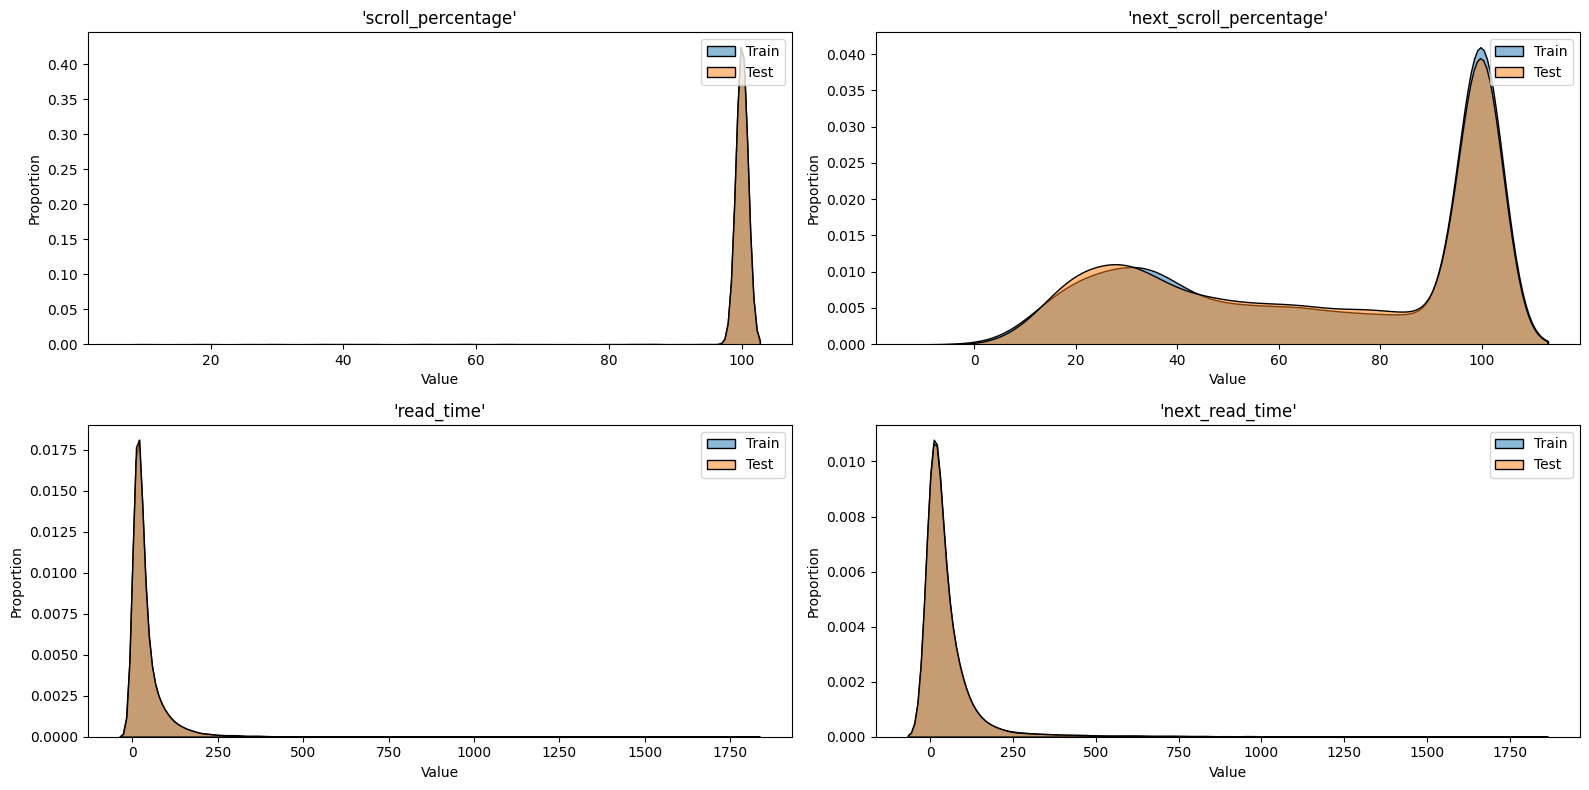

In [8]:
feat_cols = ["scroll_percentage","next_scroll_percentage", "read_time", "next_read_time"]
fig, axes = plt.subplots(nrows = 2,
                         ncols = 2)
axes = axes.flatten()
fig.set_size_inches(16, 8)

for ax, col in zip(axes, feat_cols):
    sns.kdeplot(data=train_df[col],
                ax=ax,
                label="Train",
                alpha=0.5,
                multiple="stack")
    
    sns.kdeplot(data=val_df[col],
                ax=ax,
                label="Test",
                alpha=0.5,
                multiple="stack")
    
    ax.set_title(f"'{col}'")
    ax.set_xlabel("Value")
    ax.set_ylabel("Proportion")
    ax.legend()
    
plt.tight_layout()
plt.show()

#### Categorical Distribution

In [60]:
for i in range(train_df["article_ids_clicked"].shape[0]):
    if not train_df["article_ids_clicked"][i][0] in train_df["article_ids_inview"][i]:
        print(train_df["article_ids_clicked"][0])

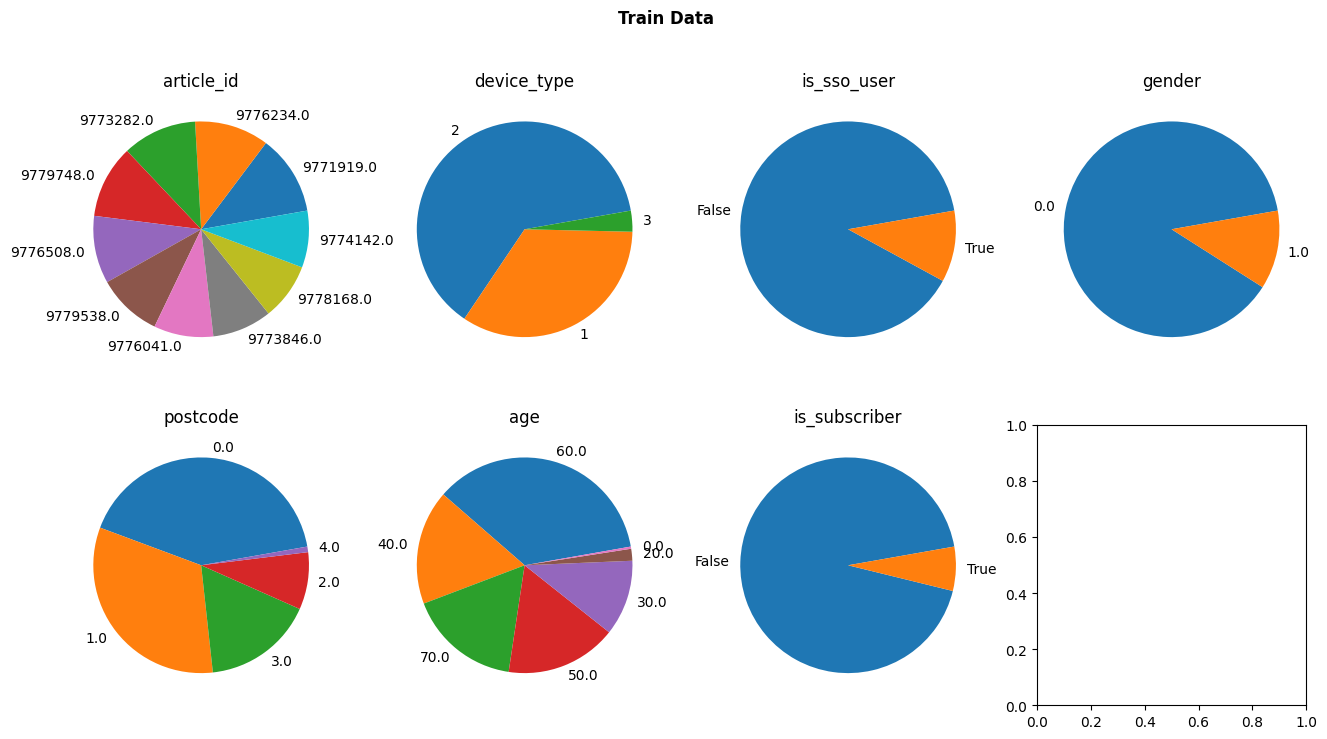

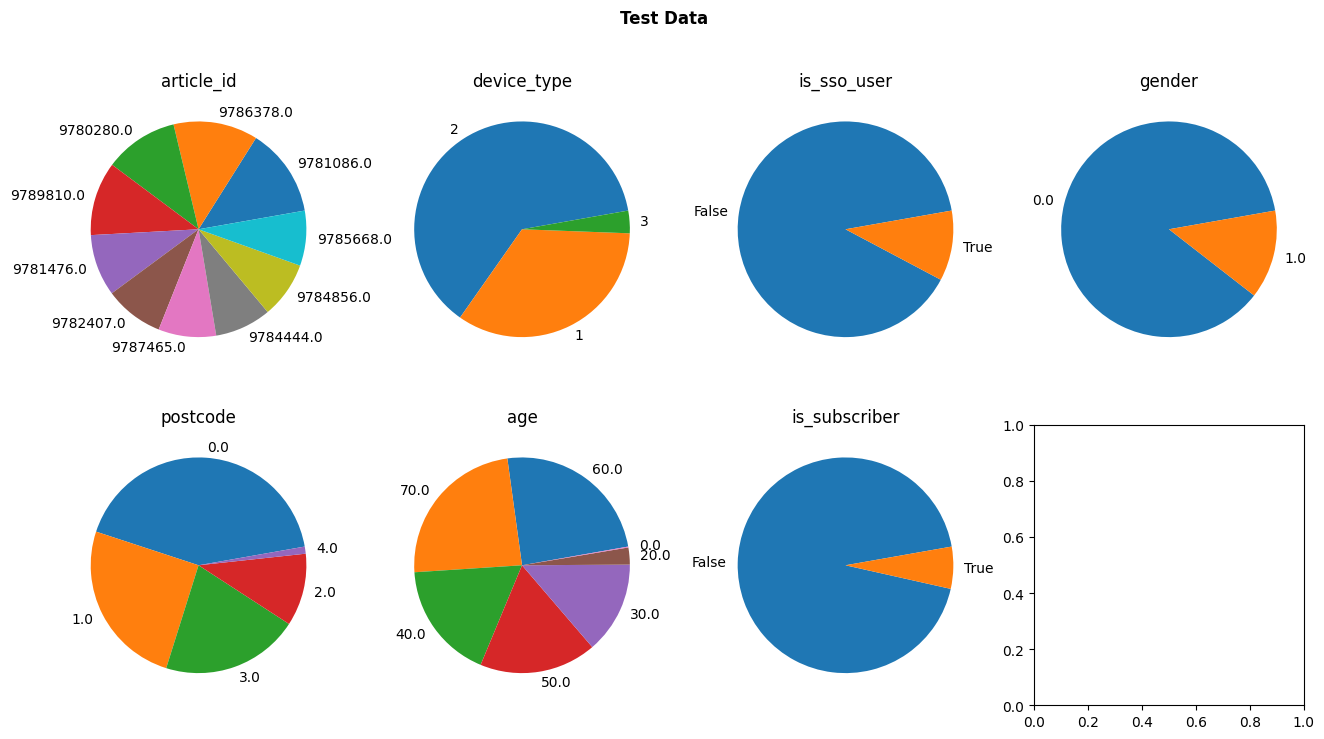

In [196]:
cat_cols = ["article_id","device_type", "is_sso_user", "gender", "postcode", "age", "is_subscriber"]

def plot_top_cats(inp_df, columns, title=""):
    top_n = 10

    fig, axs = plt.subplots(2, 4, figsize=(16, 8))  # 4 rows, 2 columns
    for i, column in enumerate(columns):
        value_counts = inp_df[column].value_counts().nlargest(top_n)
        axs[i // 4, i % 4].pie(value_counts.values, labels=value_counts.index, startangle=10)
        axs[i // 4, i % 4].set_title(f"{column}")

    plt.suptitle(title, fontweight='bold')
    plt.show()

plot_top_cats(train_df, cat_cols, "Train Data")
plot_top_cats(val_df, cat_cols, "Test Data")


In [54]:
def getNaNValueProportion(dataframe):
    nan_values = {}

    for column_name in dataframe.columns:
        nan_percentage = (dataframe[column_name].isna().sum() / dataframe.shape[0]) * 100
        nan_values[column_name] = nan_percentage
        
    sorted_nan_values = sorted(nan_values.items(), key=lambda x: x[1], reverse=True)
    print("NaN Value Percentage (Ascending Order)\n")
    for column, percentage in sorted_nan_values:
        print(f"{column}: %{percentage:.2f}")

In [55]:
getNaNValueProportion(train_df)

NaN Value Percentage (Ascending Order)

postcode: %98.54
age: %97.50
gender: %92.73
scroll_percentage: %70.71
article_id: %70.16
next_scroll_percentage: %11.15
next_read_time: %2.72
impression_id: %0.00
impression_time: %0.00
read_time: %0.00
device_type: %0.00
article_ids_inview: %0.00
article_ids_clicked: %0.00
user_id: %0.00
is_sso_user: %0.00
is_subscriber: %0.00
session_id: %0.00


### Article Dataframe Distribution

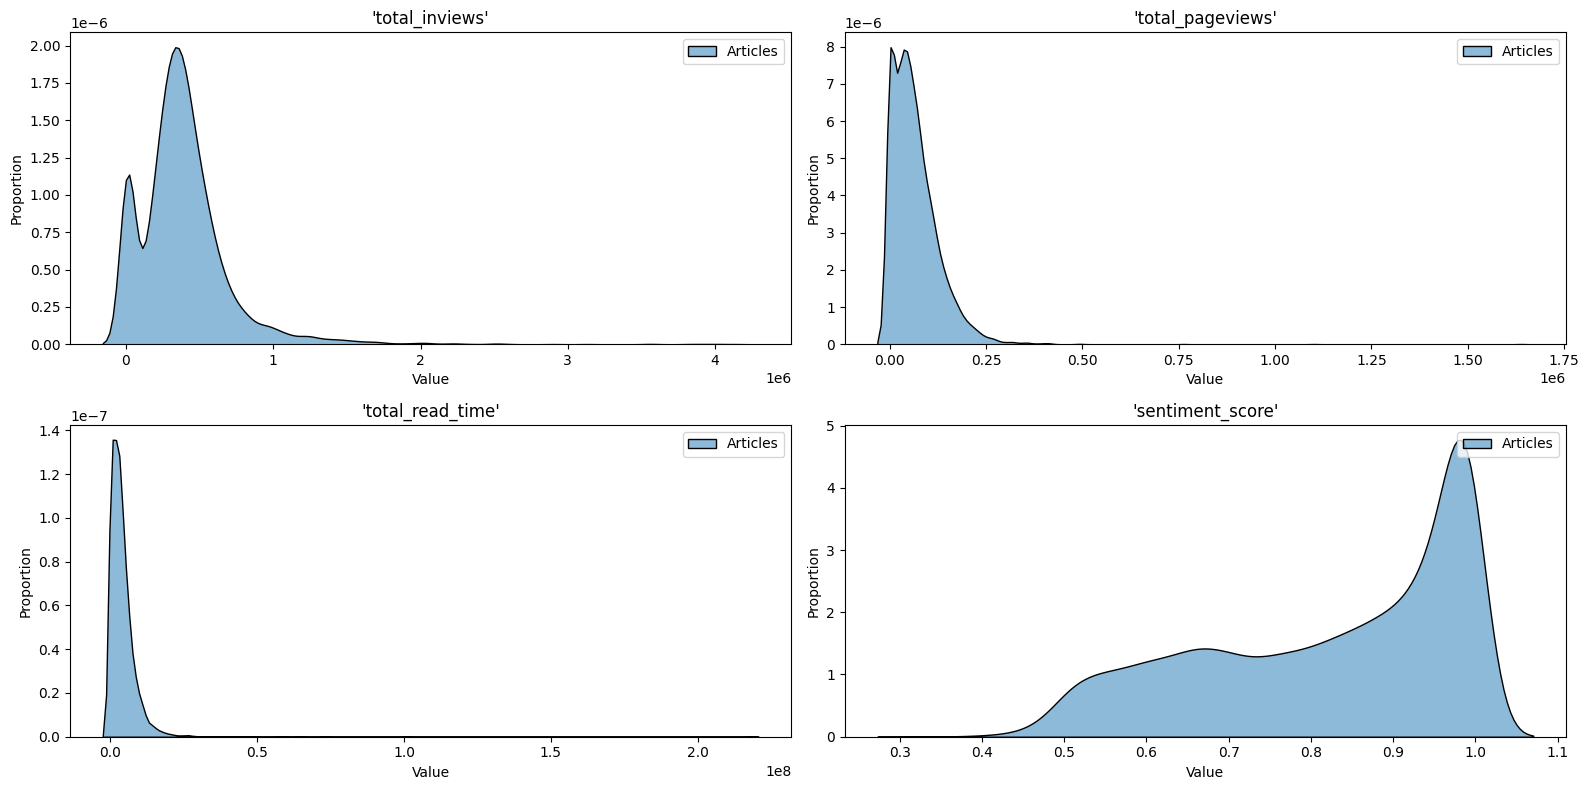

In [69]:
article_feat_cols = ["total_inviews", "total_pageviews", "total_read_time", "sentiment_score"]
fig, axes = plt.subplots(nrows = 2,
                         ncols = 2)
axes = axes.flatten()
fig.set_size_inches(16, 8)

for ax, col in zip(axes, article_feat_cols):
    sns.kdeplot(data=articles_df[col],
                ax=ax,
                label="Articles",
                alpha=0.5,
                multiple="stack")
    
    ax.set_title(f"'{col}'")
    ax.set_xlabel("Value")
    ax.set_ylabel("Proportion")
    ax.legend()
    
plt.tight_layout()
plt.show()

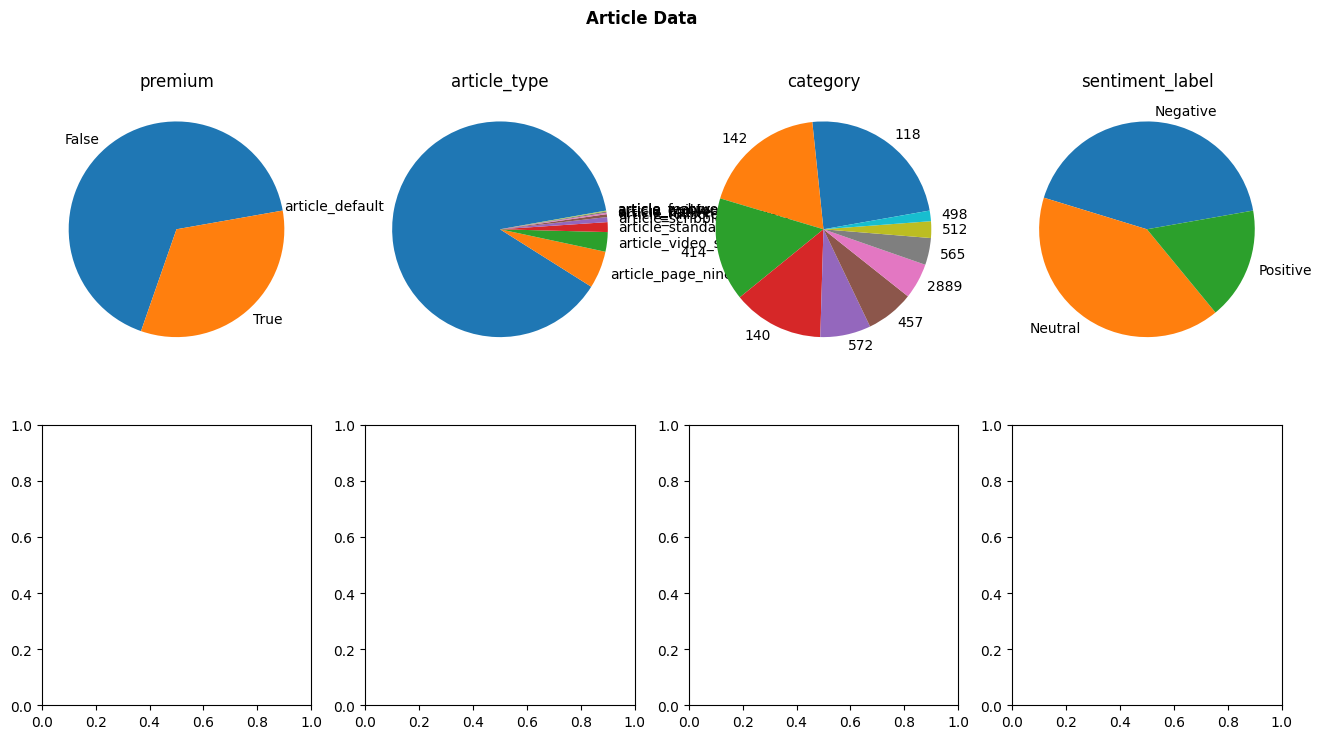

In [197]:
article_cols = ["premium","article_type", "category", "sentiment_label"]


plot_top_cats(train_article, article_cols, "Article Data")


"postcode, age, gender" features have more NaN value. So, we can ignore these features.

## Feature Engineering

### Correlation Matrix

## Data Preprocessing

### Fill Empty, NaN Items

### Add New Features

### Remove Unnecessery Column

## Training

* CATBOOST
* XGBOOST
* Deep Learning Approach

## Prediction & Result

### ROC & AUC Curve